In [1]:
import torch
import random
import numpy as np
from torch.utils.data import DataLoader, Subset , random_split
from torchvision import datasets, transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


In [3]:
# -----------------------------------------
# 2. Define transforms and load MNIST
# -----------------------------------------
class MinMaxScaler:
    def __call__(self, sample):
        return sample / 255

transform = transforms.Compose([
    transforms.ToTensor(),
    MinMaxScaler()
])

In [4]:
X_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
X_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

X_train_100 = Subset(X_train, range(100))  # First 100 samples for supervised
X_train_unsupervised = Subset(X_train, range(100, len(X_train)))  # Remaining samples for unsupervised



full_unsupervised_set = torch.utils.data.ConcatDataset([X_train_100, X_train_unsupervised])

train_size = int(0.9 * len(full_unsupervised_set))
val_size = len(full_unsupervised_set) - train_size

unsupervised_train_set, unsupervised_val_set = random_split(full_unsupervised_set, [train_size, val_size])


print(f"Unsupervised training set: {len(unsupervised_train_set)} samples")
print(f"Unsupervised validation set: {len(unsupervised_val_set)} samples")


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.83MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.30MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Unsupervised training set: 54000 samples
Unsupervised validation set: 6000 samples


In [5]:
# -----------------------------------------
# 3. Define RotationDataset for Unsupervised Learning
# -----------------------------------------

class RotationDataset(torch.utils.data.Dataset):
    """Dataset that generates rotated versions of images with rotation labels (0°, 90°)."""
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]

        rotation_angle = random.choice([0, 90])
        rotated_image = transforms.functional.rotate(image, rotation_angle)

        rotation_label = {0: 0, 90: 1}[rotation_angle]

        return rotated_image, rotation_label


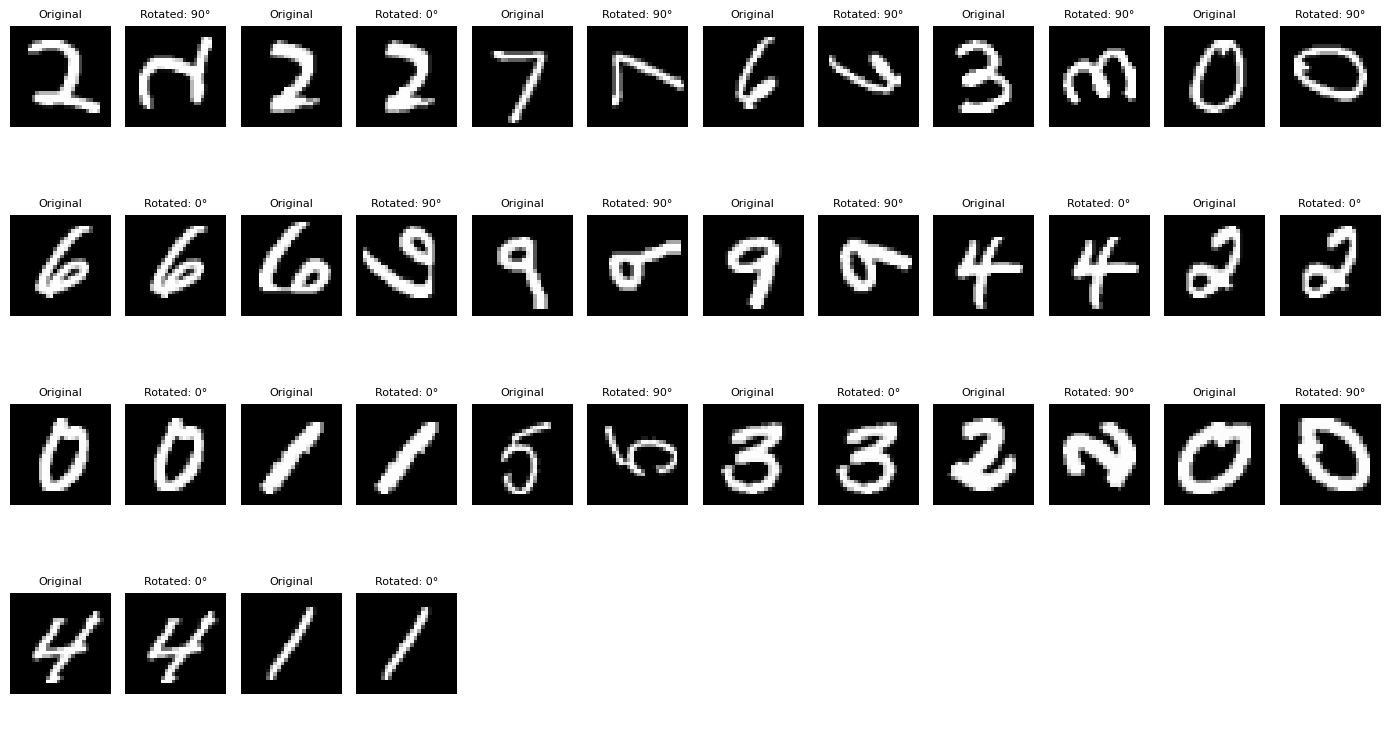

In [6]:
def visualize_original_and_rotated_images(dataset, num_images=12):
    """
    Visualize original and rotated images in a compact grid with rotation labels (0°, 90°).

    Args:
        dataset: The dataset containing images.
        num_images: Number of image pairs to visualize.
    """
    num_cols = 6
    num_rows = (num_images + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols * 2, figsize=(14, num_rows * 2))

    for i in range(num_images):
        idx = torch.randint(0, len(dataset), (1,)).item()
        original_image, _ = dataset[idx]

        rotation_angle = random.choice([0, 90])
        rotated_image = transforms.functional.rotate(original_image, rotation_angle)
        rotation_label = {0: 0, 90: 1}[rotation_angle]

        original_image = original_image.squeeze(0).numpy()
        rotated_image = rotated_image.squeeze(0).numpy()

        row, col = divmod(i, num_cols)
        original_col = col * 2
        rotated_col = col * 2 + 1

        axes[row, original_col].imshow(original_image, cmap='gray')
        axes[row, original_col].set_title("Original", fontsize=8)
        axes[row, original_col].axis('off')

        axes[row, rotated_col].imshow(rotated_image, cmap='gray')
        axes[row, rotated_col].set_title(f"Rotated: {rotation_angle}°", fontsize=8)
        axes[row, rotated_col].axis('off')

    for ax in axes.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_original_and_rotated_images(X_train_unsupervised, num_images=20)


In [7]:
# -----------------------------------------
# 4. Define RotNet Model for Rotation Prediction
# -----------------------------------------
class RotNet(nn.Module):
    """RotNet model for self-supervised rotation prediction."""
    def __init__(self):
        super(RotNet, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.rotation_head = nn.Linear(512, 2)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = x.view(x.size(0), -1)
        x = self.rotation_head(x)
        return x


In [8]:

def train_rotnet(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=True)
        for images, rotation_labels in train_bar:
            images, rotation_labels = images.cuda(), rotation_labels.cuda()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, rotation_labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            train_bar.set_postfix(loss=f"{loss.item():.4f}")

        model.eval()
        correct = 0
        total = 0

        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=True)
        with torch.no_grad():
            for images, rotation_labels in val_bar:
                images, rotation_labels = images.cuda(), rotation_labels.cuda()

                # Forward pass
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += rotation_labels.size(0)
                correct += (predicted == rotation_labels).sum().item()

        val_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


In [9]:
# Check a few samples from the dataset
for idx in range(5):
    image, label = RotationDataset(unsupervised_train_set)[idx]
    print(f"Sample {idx}: Label = {label}, Image shape = {image.shape}")


Sample 0: Label = 0, Image shape = torch.Size([1, 28, 28])
Sample 1: Label = 1, Image shape = torch.Size([1, 28, 28])
Sample 2: Label = 1, Image shape = torch.Size([1, 28, 28])
Sample 3: Label = 0, Image shape = torch.Size([1, 28, 28])
Sample 4: Label = 0, Image shape = torch.Size([1, 28, 28])


In [10]:
rotnet = RotNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rotnet.parameters(), lr=0.001)


unsupervised_train_loader = DataLoader(RotationDataset(unsupervised_train_set), batch_size=64, shuffle=True)
unsupervised_val_loader = DataLoader(RotationDataset(unsupervised_val_set), batch_size=64, shuffle=False)


# Train RotNet
train_rotnet(rotnet, unsupervised_train_loader, unsupervised_val_loader, criterion, optimizer, num_epochs=5)


Epoch 1/5 [Training]:   0%|          | 0/844 [00:00<?, ?it/s]

Epoch 1/5 [Validation]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch [1/5], Loss: 203.1741, Validation Accuracy: 96.72%


Epoch 2/5 [Training]:   0%|          | 0/844 [00:00<?, ?it/s]

Epoch 2/5 [Validation]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch [2/5], Loss: 33.0460, Validation Accuracy: 99.05%


Epoch 3/5 [Training]:   0%|          | 0/844 [00:00<?, ?it/s]

Epoch 3/5 [Validation]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch [3/5], Loss: 23.1220, Validation Accuracy: 99.33%


Epoch 4/5 [Training]:   0%|          | 0/844 [00:00<?, ?it/s]

Epoch 4/5 [Validation]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch [4/5], Loss: 18.9253, Validation Accuracy: 99.15%


Epoch 5/5 [Training]:   0%|          | 0/844 [00:00<?, ?it/s]

Epoch 5/5 [Validation]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch [5/5], Loss: 19.5287, Validation Accuracy: 99.08%


In [11]:
# -----------------------------------------
# 6. Define Classifier with Conv Head for Supervised Learning
# -----------------------------------------
class FeatureExtractor(nn.Module):
    """Extract features from the first two blocks of RotNet."""
    def __init__(self, rotnet):
        super(FeatureExtractor, self).__init__()
        self.block1 = rotnet.block1
        self.block2 = rotnet.block2

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        return x

class MNISTClassifierWithConvHead(nn.Module):
    """MNIST classifier with an additional convolutional block and fully connected layer."""
    def __init__(self):
        super(MNISTClassifierWithConvHead, self).__init__()
        self.conv_head = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 3 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_head(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [20]:
# -----------------------------------------
# 7. Train Classifier on Supervised Dataset
# -----------------------------------------
def train_classifier(feature_extractor, classifier, dataloader, criterion, optimizer, num_epochs=400):
    feature_extractor.eval()  # Freeze feature extractor
    classifier.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in dataloader:
            images, labels = images.cuda(), labels.cuda()
            with torch.no_grad():  # Extract features
                features = feature_extractor(images)
            outputs = classifier(features)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

feature_extractor = FeatureExtractor(rotnet).cuda()
classifier = MNISTClassifierWithConvHead().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

# Create DataLoader for supervised dataset
supervised_loader = DataLoader(X_train_100, batch_size=16, shuffle=True)

# Train Classifier
train_classifier(feature_extractor, classifier, supervised_loader, criterion, optimizer)

Epoch [1/400], Loss: 16.0784
Epoch [2/400], Loss: 15.9270
Epoch [3/400], Loss: 15.7987
Epoch [4/400], Loss: 15.5699
Epoch [5/400], Loss: 15.3937
Epoch [6/400], Loss: 15.2347
Epoch [7/400], Loss: 15.0663
Epoch [8/400], Loss: 14.6676
Epoch [9/400], Loss: 14.4280
Epoch [10/400], Loss: 13.6587
Epoch [11/400], Loss: 13.1423
Epoch [12/400], Loss: 12.4562
Epoch [13/400], Loss: 11.8564
Epoch [14/400], Loss: 11.0413
Epoch [15/400], Loss: 10.1276
Epoch [16/400], Loss: 9.6913
Epoch [17/400], Loss: 8.9303
Epoch [18/400], Loss: 8.5085
Epoch [19/400], Loss: 7.9765
Epoch [20/400], Loss: 7.4143
Epoch [21/400], Loss: 7.3955
Epoch [22/400], Loss: 7.2385
Epoch [23/400], Loss: 6.0582
Epoch [24/400], Loss: 6.5646
Epoch [25/400], Loss: 6.2678
Epoch [26/400], Loss: 5.1911
Epoch [27/400], Loss: 5.4456
Epoch [28/400], Loss: 4.9076
Epoch [29/400], Loss: 4.8494
Epoch [30/400], Loss: 4.9568
Epoch [31/400], Loss: 4.2054
Epoch [32/400], Loss: 4.3513
Epoch [33/400], Loss: 3.8701
Epoch [34/400], Loss: 3.8246
Epoch [3

In [21]:
# -----------------------------------------
# 8. Evaluate Classifier on Test Set
# -----------------------------------------
def evaluate_classifier(feature_extractor, classifier, dataloader):
    feature_extractor.eval()
    classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.cuda(), labels.cuda()
            features = feature_extractor(images)
            outputs = classifier(features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Evaluate Classifier
test_loader = DataLoader(X_test, batch_size=64, shuffle=False)
evaluate_classifier(feature_extractor, classifier, test_loader)

Test Accuracy: 65.93%
